# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling

from ipywidgets import widgets
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

%matplotlib inline

# Análise com Pandas

**Variáveis do dataset**

**step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo equivale a 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. (caixa de entrada, caixa de saída, débito, pagamento e transferência).

**amount** - valor da transação em moeda local.

**nameOrig** - cliente que iniciou a transação.

**oldbalanceOrg** - saldo inicial antes da transação.

**newbalanceOrig** - novo saldo após a transação.

**nameDest** - cliente que é o destinatário da transação.

**oldbalanceDest** - destinatário do saldo inicial antes da transação. Obsevamos que não há informações para clientes que começam com M (comerciantes).

**newbalanceDest** - novo destinatário do saldo após a transação. Obsevamos que não há informações para clientes que começam com M (comerciantes).

**isFraud** - são as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e depois sacando do sistema.

**isFlaggedFraud** - o modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

In [3]:
df = pd.read_csv("data\fraud_dataset_example.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Trazendo as colunas de fraude para o começo do dataset

In [6]:
df = df[['isFraud', 'isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']]
df.head()

,isFraud,isFlaggedFraud,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


# Renomeando as colunas

In [7]:
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

In [8]:
df = df.rename(columns=colunas)
df.head()

,fraude,super_fraude,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


# Outras informações do dataset

In [9]:
df.describe()

,fraude,super_fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2
count,101613.000000,101613.0,101613.000000,1.016130e+05,1.016130e+05,1.016130e+05,1.016130e+05,1.016130e+05
mean,0.001142,0.0,8.523457,1.740901e+05,9.071753e+05,9.234992e+05,8.810428e+05,1.183998e+06
std,0.033768,0.0,1.820681,3.450199e+05,2.829575e+06,2.867319e+06,2.399949e+06,2.797761e+06
min,0.000000,0.0,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.0,8.000000,1.001659e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.0,9.000000,5.338541e+04,2.019047e+04,0.000000e+00,2.105800e+04,5.178343e+04
75%,0.000000,0.0,10.000000,2.124984e+05,1.947150e+05,2.192178e+05,5.919217e+05,1.063122e+06
max,1.000000,0.0,10.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.400874e+07,3.894623e+07


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraude,101613.0,1.141586e-03,3.376824e-02,0.00,0.00,0.00,0.00,1.00
super_fraude,101613.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00
tempo,101613.0,8.523457e+00,1.820681e+00,1.00,8.00,9.00,10.00,10.00
valor,101613.0,1.740901e+05,3.450199e+05,0.32,10016.59,53385.41,212498.40,10000000.00
saldo_inicial_c1,101613.0,9.071753e+05,2.829575e+06,0.00,0.00,20190.47,194715.00,38939424.03
novo_saldo_c1,101613.0,9.234992e+05,2.867319e+06,0.00,0.00,0.00,219217.76,38946233.02
saldo_inicial_c2,101613.0,8.810428e+05,2.399949e+06,0.00,0.00,21058.00,591921.70,34008736.98
novo_saldo_c2,101613.0,1.183998e+06,2.797761e+06,0.00,0.00,51783.43,1063121.64,38946233.02


In [11]:
df.shape

(101613, 11)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   tipo              101613 non-null  object 
 4   valor             101613 non-null  float64
 5   cliente1          101613 non-null  object 
 6   saldo_inicial_c1  101613 non-null  float64
 7   novo_saldo_c1     101613 non-null  float64
 8   cliente2          101613 non-null  object 
 9   saldo_inicial_c2  101613 non-null  float64
 10  novo_saldo_c2     101613 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


In [13]:
df.groupby('fraude').tempo.count()

fraude
0    101497
1       116
Name: tempo, dtype: int64

In [14]:
df.isnull().values.any()

False

# Enconding

## Pandas Profiling

In [16]:
profile = ydata_profiling.ProfileReport(df)

In [17]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Aplicando o Encoding

**Tipos de enconding**

**Label Encoding** - Renomea as classes com valores numéricos de 1 a **n**, sendo **n** o número de classes. Pode existir hierarquia entre as classes.

**One-Hot Encoding** - Transforma as variáveis em **n** colunas binárias, sendo **n** o número de classes. Todas as classes são analisadas de forma igual, quando tiver a ocorrência delea a coluna terá o valor 1 e quando não, o valor 0, isso acontece para as demais colunas criadas.

In [18]:
df = pd.get_dummies(data=df, columns=['tipo'])
df.head()

,fraude,super_fraude,tempo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0
1,0,0,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0
2,1,0,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,0,0,0,1
3,1,0,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1,0,0,0
4,0,0,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0


## Removendo variáveis

In [19]:
df = df.drop(['cliente1', 'cliente2', 'super_fraude'], axis=1)
df.head()

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,0,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


# Regressão Logística

In [20]:
x = df.drop('fraude', axis=1)
y = df['fraude']

In [21]:
SEED = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=SEED)

In [22]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Acurácia:", metrics.accuracy_score(y_test, y_pred))
print("Precisão:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1:", metrics.f1_score(y_test, y_pred))

Acurácia: 0.9989765391276965
Precisão: 0.2
Recall: 0.043478260869565216
F1: 0.07142857142857142


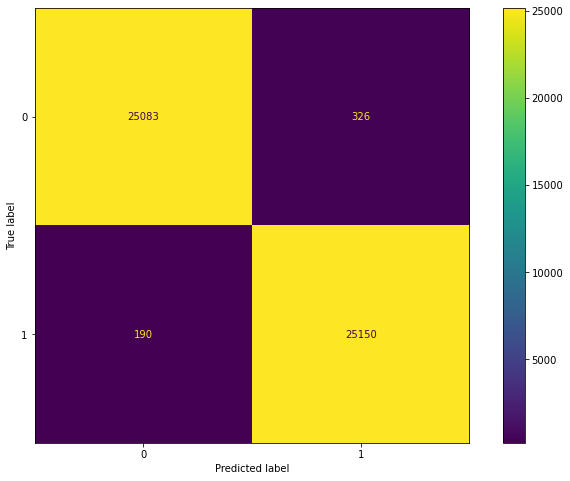

In [58]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

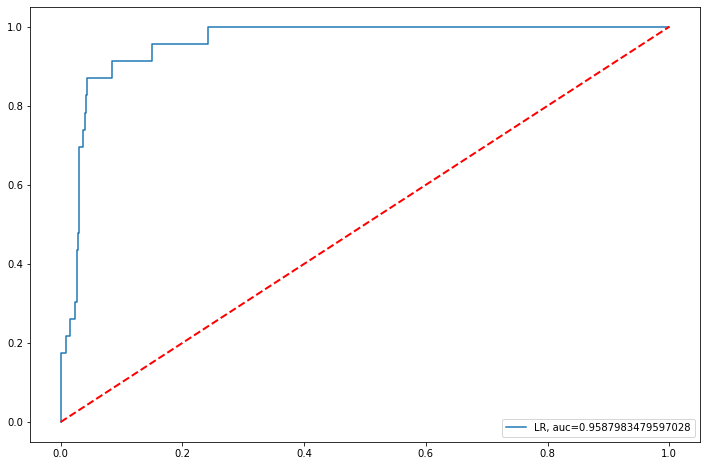

In [24]:
y_pred_proba = lr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

# Balanceamento de dados

Existem dois tipos possíveis de balanceamento de dados: o undersampling e o oversampling. A primeira opção, undersampling, reduz todos os dados da nossa opção majoritária, isto é, de não fraude, para 116 dados, o que não faz tanto sentido no nosso caso, considerando que já não temos muitos dados de fraude e não teríamos tantos dados para treinamento. Seria complicado continuar fazendo as nossas análises e elas não trariam uma boa acurácia.

A segunda opção, oversampling, é basicamente duplicar, fazer a cópia dos nossos dados da classe minoritária até chegar no valor da classe majoritária. Então, ela faria cópia dos dados de fraude, ou seja, criaria novos dados até chegarmos ao número de dados de não fraude.

O oversampling apresenta alguns problemas quando tratamos de uma base de dados do mundo real, por exemplo, se tivéssemos utilizando a base de dados de um banco. Nesse caso, teríamos clientes reais e criaríamos dados sintéticos que trariam algum problema para as análises.

Não teríamos certeza sobre os comportamentos dos clientes. Existem outros casos que podemos analisar com o oversampling, mas como já estamos trabalhando com uma base de dados sintéticos, não tem problema criarmos outros dados sintéticos. Também existem outras formas de driblarmos essa criação aleatória de dados. Uma delas é a técnica Smote, que utiliza KNN (K Nearest Neighbor).

In [25]:
SEED = 42
smote = SMOTE(random_state=SEED)

In [26]:
x = df.drop('fraude', axis=1)
y = df['fraude']

In [27]:
x_resample, y_resample = smote.fit_resample(x, y)

In [28]:
df_balanced = pd.concat([y_resample, x_resample], axis=1)
df_balanced

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.640000,170136.000000,160296.36,0.000000,0.000000,0,0,0,1,0
1,0,1,1864.280000,21249.000000,19384.72,0.000000,0.000000,0,0,0,1,0
2,1,1,181.000000,181.000000,0.00,0.000000,0.000000,0,0,0,0,1
3,1,1,181.000000,181.000000,0.00,21182.000000,0.000000,0,1,0,0,0
4,0,1,11668.140000,41554.000000,29885.86,0.000000,0.000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
202989,1,5,17608.962863,17608.962863,0.00,0.000000,0.000000,0,0,0,0,1
202990,1,7,12116.291013,12116.291013,0.00,0.000000,0.000000,0,0,0,0,1
202991,1,1,231612.880715,231612.880715,0.00,1945.589357,9370.603471,0,0,0,0,0
202992,1,9,547325.144758,547325.144758,0.00,0.000000,0.000000,0,0,0,0,1


In [29]:
df_balanced.groupby('fraude').tempo.count()

fraude
0    101497
1    101497
Name: tempo, dtype: int64

### Novo teste do LR

In [30]:
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values

In [31]:
SEED = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=SEED)

In [32]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Acurácia:", metrics.accuracy_score(y_test, y_pred))
print("Precisão:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1:", metrics.f1_score(y_test, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


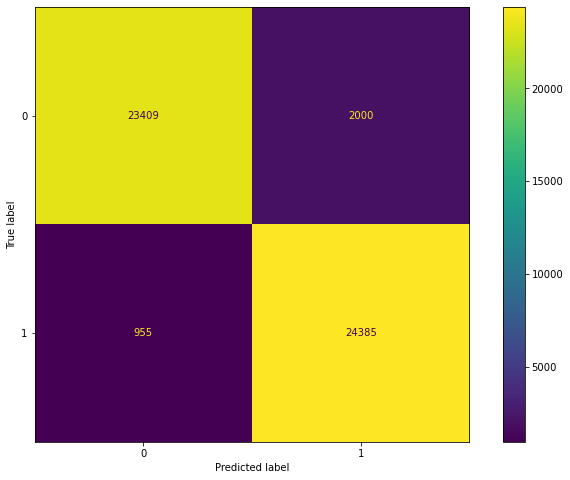

In [33]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

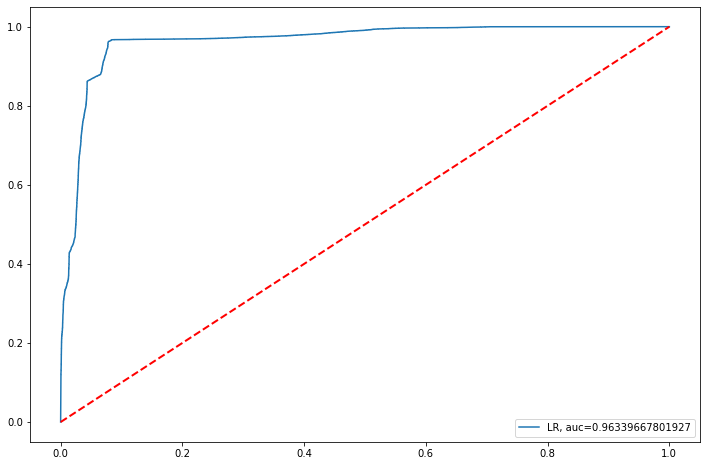

In [34]:
y_pred_proba = lr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

### Formulando as hipóteses

In [35]:
profile = ydata_profiling.ProfileReport(df_balanced)

In [36]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Hipóteses



*   tipo_PAYMENT é o que a pessoa utiuliza como padrão e a fraude ocorre por meio do tipo_TRANSFER
*   O cliente pode fazer seus pagamentos durante um período do dia, como por exemplo durante a manhã, e a fraude ocorre durante um período diferente, como a madrugada.
*   O cliente paga as suas contas no começo do mês e houve uma movimentação no final do mês, sendo uma fraude.



# Árvore de Decisão

In [37]:
dt = DecisionTreeClassifier(max_depth=5, random_state=SEED)

In [38]:
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

print("Acurácia:", metrics.accuracy_score(y_test, y_pred))
print("Precisão:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1:", metrics.f1_score(y_test, y_pred))

Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


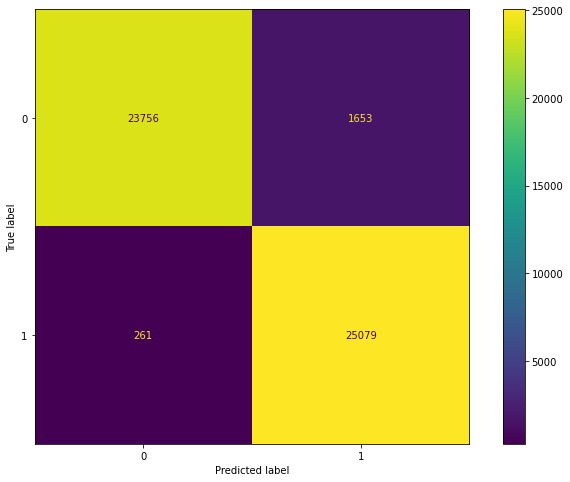

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

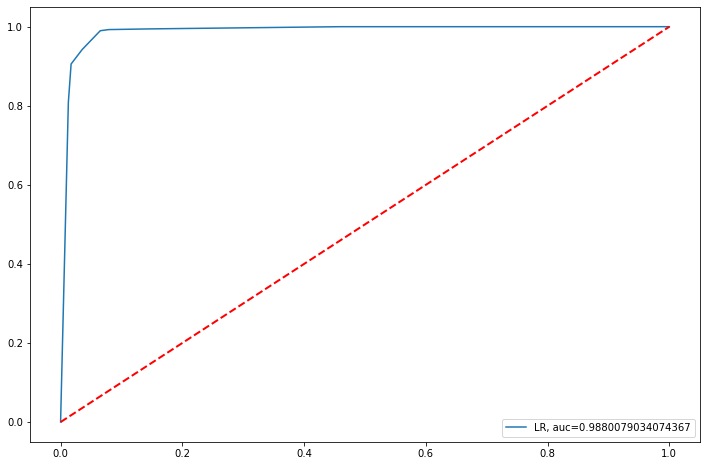

In [40]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

# Random Forest

In [41]:
rf = RandomForestClassifier(max_depth=5, random_state=SEED)

In [42]:
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("Acurácia:", metrics.accuracy_score(y_test, y_pred))
print("Precisão:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1:", metrics.f1_score(y_test, y_pred))

Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


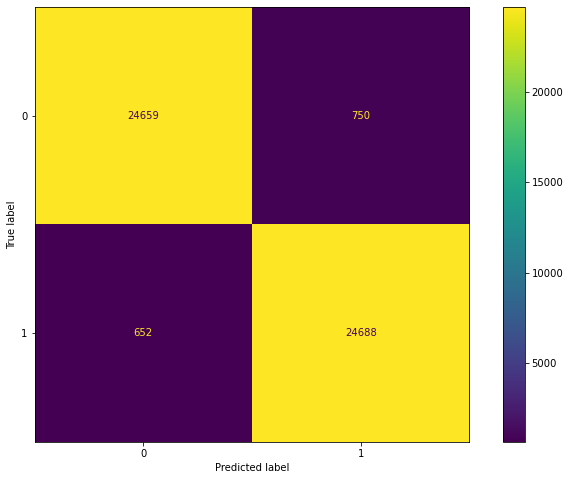

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

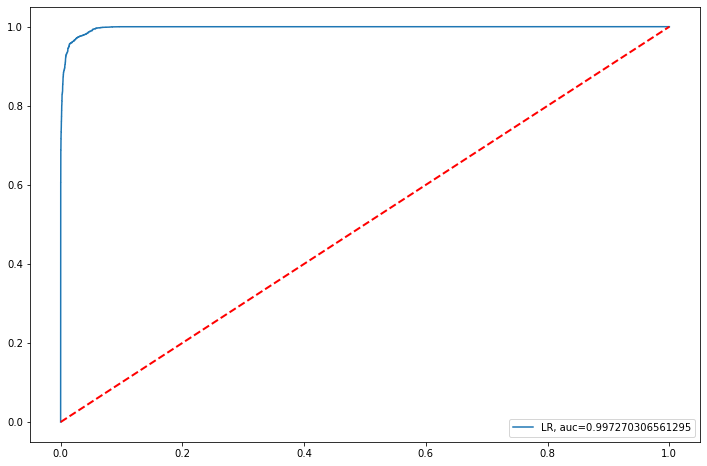

In [44]:
y_pred_proba = rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

# Análise de Métricas

In [45]:
classifiers = [
    LogisticRegression(max_iter=1000, random_state=SEED),
    DecisionTreeClassifier(max_depth=5, random_state=SEED),
    RandomForestClassifier(max_depth=5, random_state=SEED)
]

LogisticRegression
*** Resultados ***
Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975
DecisionTreeClassifier
*** Resultados ***
Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943
RandomForestClassifier
*** Resultados ***
Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


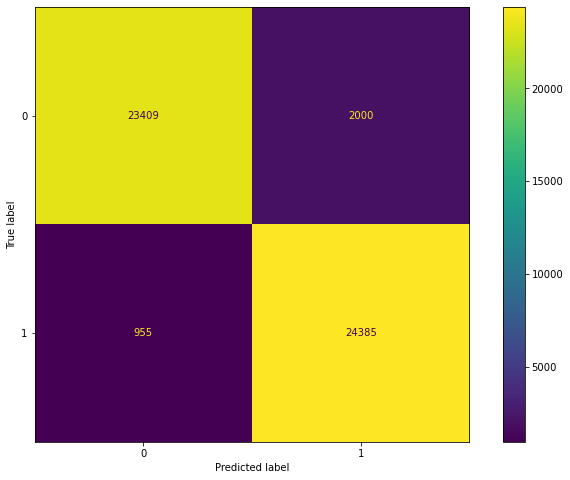

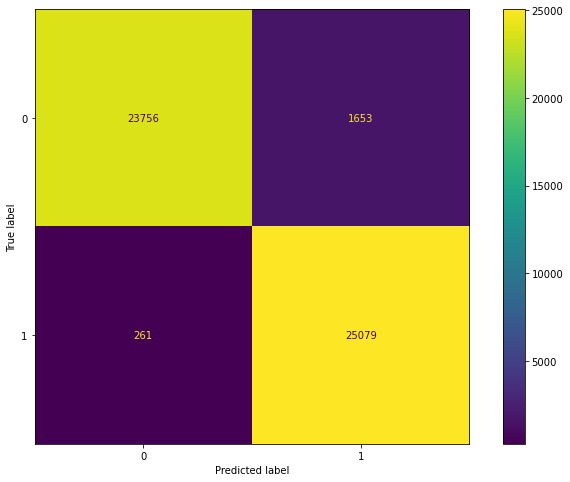

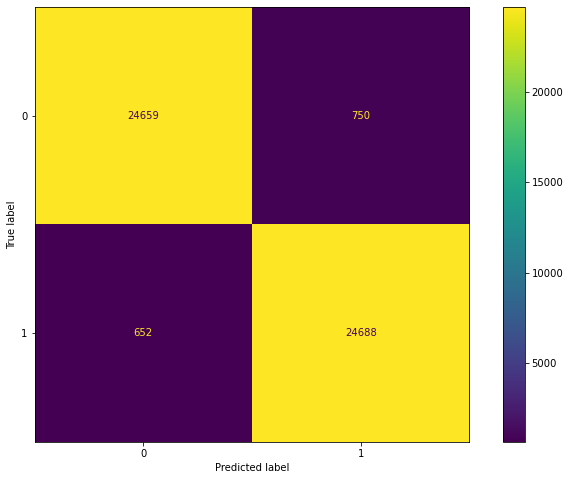

In [46]:
for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    print("="*30)
    print(name)
    print("*** Resultados ***")
    y_pred = clf.predict(x_test)
    
    print("Acurácia:", metrics.accuracy_score(y_test, y_pred))
    print("Precisão:", metrics.precision_score(y_test, y_pred))
    print("Recall:", metrics.recall_score(y_test, y_pred))
    print("F1:", metrics.f1_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

# Melhorando o modelo

In [47]:
n_estimator = np.arange(20, 200, step=20)
criterion = ['gini','entropy']
max_features = ['auto','sqrt','log2']
max_depth = list(np.arange(2, 10, step=2))
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [48]:
param_grid = {
    "n_estimators": n_estimator,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

In [49]:
SEED = 70
rforest = RandomForestClassifier(random_state=SEED)

In [50]:
random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter=5, cv=3, scoring='recall', n_jobs=-1, random_state=SEED
)

In [51]:
%%time
rcv = random_cv.fit(x,y)

CPU times: total: 7.45 s
Wall time: 1min 36s


In [52]:
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,32.588144,0.844401,1.355897,0.094073,160,4,sqrt,6,gini,True,"{'n_estimators': 160, 'min_samples_leaf': 4, '...",0.977950,0.999941,0.972718,0.983536,0.011795,2
1,36.196470,1.319996,0.843442,0.028883,100,1,auto,6,entropy,False,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.974314,0.999970,0.963437,0.979241,0.015316,3
2,21.822968,0.629332,0.609198,0.021912,80,1,sqrt,4,entropy,False,"{'n_estimators': 80, 'min_samples_leaf': 1, 'm...",0.951762,0.995980,0.956107,0.967950,0.019900,4
3,30.255117,1.341056,0.661840,0.032417,120,1,auto,8,gini,False,"{'n_estimators': 120, 'min_samples_leaf': 1, '...",0.987349,0.999970,0.991251,0.992857,0.005276,1
4,17.368816,0.417031,0.624850,0.059460,100,1,sqrt,4,entropy,True,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.943101,0.995980,0.949486,0.962856,0.023567,5


In [53]:
rcv.best_params_

{'n_estimators': 120,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'gini',
 'bootstrap': False}

# Resultados finais

In [54]:
rfn = RandomForestClassifier(**rcv.best_params_, random_state=SEED)

model = rfn.fit(x_train, y_train)
y_pred = rfn.predict(x_test)

In [55]:
print("Acurácia:", metrics.accuracy_score(y_test, y_pred))
print("Precisão:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1:", metrics.f1_score(y_test, y_pred))

Acurácia: 0.9898323119667383
Precisão: 0.9872036426440571
Recall: 0.9925019731649566
F1: 0.989845717884131


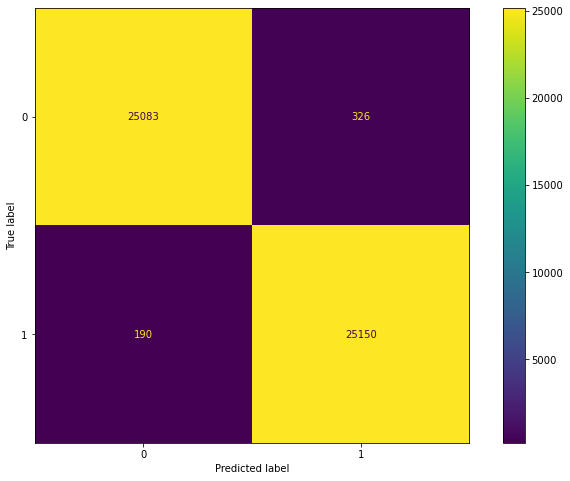

In [56]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

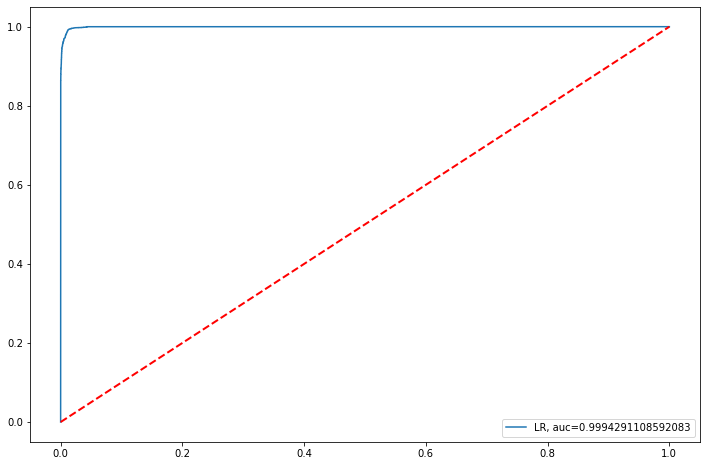

In [57]:
y_pred_proba = rfn.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

# Conclusão

• O(a) cliente tem um certo padrão de movimentação do dinheiro, em horário comercial, e a fraude ocorreu fora deste horário, como por exemplo durante a madrugada.

• Ainda em relação ao tempo, o cliente pode fazer suas principais movimentações em um período inicial do mês e a fraude foi vista em um dia não habitual.

      - Fazer um CAPTCHA para aumentar a segurança em horários não convencionais.

• O(a) cliente utiliza como padrão o pagamento em dinheiro, seja por PIX ou retirada*, e a fraude pode ocorrer por um pagamento por transferência.

      - Solicitar uma verificação de informação adicional do banco, como uma pergunta de segurança, para movimentações de transferência.